### Important variables 

Deptext = Depression text-response <br> 
Wortext = Worry text-response

dep_all_phraces = Depression all phraces responses <br> 
wor_all_phraces = Worry all phraces responses

dep_all_word = Depression all descriptive word responses <br>
wor_all_words = Worry all descriptive word responses

dep_all_selected1 = All selected depression word responses <br>
wor_all_selected1 = All selected worry word responses

<hr style="border:1px solid gray"> </hr>

CESDtot = Center for Epidemiological Studies Depression (CESD) <br>
PHQtot = PHQ-9 = Patient Helath Questionnaire = a depression scale

GADtot = GAD-7 = Generalized anxiety disorder scale <br>
PSWQtot = Penn State Worry Questionniare 

<hr style="border:1px solid gray"> </hr>

miniGAD_diagnose = Self-reported MINI (structured interview) GAD diangose <br>
minidep_diagnose = Self-reported MINI (structured interview) MDD (depression) diangose

#### Importing and cleaning dataset

In [1]:
import keras
import math
import numpy as np
import os
import pandas as pd
import re
from sklearn import preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download()

Using TensorFlow backend.


In [2]:
#Get relative directory to find path
path = os.path.join(os.getcwd(), 'data', 'response_format_cleaned_ds1.csv')
responses = pd.read_csv(path, sep=';', header=0)
responses.drop(responses.columns[[0]], axis=1, inplace=True)
responses.head()

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,sequence1,seqOne,Dep5words[Word1],...,wor_all_selected,wor_all_selected1,minidep_scale,minidep_diagnose,depression_episodes,miniGAD_scale,miniGAD_symptoms_scale,miniGAD_diagnose,minidiagnose_category,minidiagnose_category_number
0,434.0,2020-08-07 11:46:22,15.0,en,6.593644e+08,2020-08-07 11:38:22,2020-08-07 11:46:22,2.0,1.0,motivated,...,NA NA happy NA NA NA NA NA NA NA NA NA NA care...,happy carefree satisfied ...,0.0,0,0,0,0,0,NoDi,0
1,184.0,2020-08-07 11:58:36,15.0,en,2.803892e+08,2020-08-07 11:34:31,2020-08-07 11:58:36,2.0,1.0,connected,...,anxious NA NA NA NA NA NA NA NA NA NA tense NA...,anxious tense fearful sad fe...,3.0,0,0,8,5,0,NoDi,0
2,330.0,2020-08-07 11:51:54,15.0,en,6.770686e+07,2020-08-07 11:36:32,2020-08-07 11:51:54,1.0,1.0,Yes,...,anxious NA NA NA NA NA worried NA NA NA NA NA ...,anxious worried scared sad mon...,7.0,0,5,9,5,0,NoDi,0
3,630.0,2020-08-07 13:22:42,15.0,en,1.176643e+09,2020-08-07 12:55:26,2020-08-07 13:22:42,3.0,1.0,minor,...,anxious NA NA NA NA concerned NA NA NA NA NA t...,anxious concerned tense scared ...,3.0,0,5,8,5,0,NoDi,0
4,400.0,2020-08-07 12:04:52,15.0,en,1.012492e+09,2020-08-07 11:37:19,2020-08-07 12:04:52,1.0,1.0,family,...,NA NA NA NA NA concerned NA NA NA NA NA tense ...,concerned tense sad tired ...,4.0,0,2,7,4,1,GAD,2


### Dataset distribution for: 
#### dep vs. non-dep resonses & anx vs. non-anx responses

In [3]:
print("Count responses with/without diagnosed depression:\n",responses.minidep_diagnose.value_counts())
print("\nCount responses with/without diagnosed anxiety:\n",responses.miniGAD_diagnose.value_counts())

Count responses with/without diagnosed depression:
 0    652
1    324
Name: minidep_diagnose, dtype: int64

Count responses with/without diagnosed anxiety:
 1    499
0    477
Name: miniGAD_diagnose, dtype: int64


#### Importing and cleaning semantic space 

In [4]:
"""
Using 5-gram contexts from the database, a co-occurrence (word by word) matrix was set up, 
where the rows contained the 120,000 most common words in the n-gram database and the columns 
consisted of the 10,000 most common words in the n-gram database.

The variable 'space' is a matrix of the semantic space with dimentions reduced to 512.
"""
path = os.path.join(os.getcwd(), 'data', 'spaceEnglish1.csv')
space = pd.read_csv(path, encoding= 'unicode_escape')
space.set_index('words', inplace=True)
space.drop(space.columns[[0]], axis=1, inplace=True)
space.dropna(inplace=True)
space = space[~space.index.duplicated(keep='first')]

In [5]:
space.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512
words,,,,,,,,,,,,,,,,,,,,,
was,-0.234071,-0.278211,-0.100658,-0.269570,-0.115498,-0.000038,-0.036835,0.024037,-0.003974,0.006582,...,-0.011414,0.018075,-0.020312,0.001287,0.024483,0.012867,0.021265,0.016368,0.024858,-0.020382
not,-0.283230,-0.338776,-0.141085,-0.243715,-0.236692,-0.033354,-0.099906,0.053253,-0.025582,-0.040372,...,-0.028472,0.048824,-0.025452,0.007828,0.027658,-0.022135,0.023037,0.005371,-0.001482,-0.024063
by,-0.251058,-0.327183,-0.203889,-0.283337,-0.124522,-0.006537,0.015371,0.131667,-0.130597,0.055605,...,-0.001550,0.027915,-0.012646,-0.005019,0.075544,0.014663,0.013489,-0.022636,0.010127,-0.027951
that,-0.281888,-0.346746,-0.171006,-0.266698,-0.208917,-0.019832,-0.035404,0.044301,-0.076601,0.021328,...,0.019319,0.042742,0.001747,0.019198,0.022598,0.034352,0.033282,-0.006843,0.027052,-0.013623
of,-0.256530,-0.335434,-0.229791,-0.256070,-0.120020,0.017080,0.078004,0.112134,-0.073805,0.098183,...,0.012012,0.005470,-0.022383,-0.042172,-0.003430,-0.013435,0.003697,-0.022769,0.024873,0.010061


#### Methods for cleaning and aggregating semantic responses

In [5]:
"""
Cleans the string from punctuations and removes all words which are not represented in the semantic space. 
"""
words_in_space = set(space.index.values)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        try:
            tokens = word_tokenize(text)
            words = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.isalpha()]
            #words = [w for w in words if not w in stop_words] #Uncomment if stop words should be excluded
            cleaned_words = [w for w in words if w in words_in_space] # TODO: Hantera ord som inte finns i spacet. Nu ignoreras dem.
            return cleaned_words
        except Exception as e: 
            print(e)
    elif math.isnan(text):
        return []

In [6]:
"""
Controlling for artifacts relating to frequently occurring words.

1) Calculate, from Google N-gram, a frequency weighted average of all semantic representations in the space.
   (So that the weighting is proportional to how frequently the words occur in Google N-gram.)
2) Subtract this mean prior to aggregating each word, and then add to the final value.
"""

space_mean = pd.Series.to_numpy(space.mean())

def aggregating_words(responses):
    res_arr = np.zeros(512)
    
    for word in responses:
        word_arr = pd.Series.to_numpy(space.loc[word])
        res_arr = res_arr + (word_arr - space_mean)
    
    res_arr += space_mean    
    res_arr = res_arr / res_arr.sum() # Normalizing aggregated vector
    return res_arr

In [7]:
def aggregate_cell(text):
    words_in_cell = pd.Series.apply(text, clean_text)
    cell_vectors = pd.Series.apply(words_in_cell, aggregating_words)
    return cell_vectors

#### Extracting semantic responses and representing the answer to each question in the semantic space. 

In [8]:
dep_columns = ['Deptext', 'dep_all_phraces', 'dep_all_words', 'dep_all_selected1']
df_dep_responses = responses[dep_columns]
df_dep_aggregated = df_dep_responses.apply(aggregate_cell, axis=1)

In [9]:
wor_columns = ['Wortext', 'wor_all_phraces', 'wor_all_words', 'wor_all_selected1']
df_wor_responses = responses[wor_columns]

df_wor_aggregated = df_wor_responses.apply(aggregate_cell, axis=1)

In [11]:
df_dep_aggregated.iloc[:10]

,Deptext,dep_all_phraces,dep_all_words,dep_all_selected1
0,"[0.13613790309834575, 0.1927590671026069, 0.03...","[-0.7590918166513146, -0.7996448245182229, 0.6...","[-0.12735496139054883, -0.08134255488745973, 0...","[-0.10631367041145826, -0.07611765664843519, 0..."
1,"[0.1825447368707928, 0.25064255992349477, 0.00...","[0.3541407136004045, 0.4679208650672392, -0.00...","[1.4817085495650775, 1.6852794755670581, -1.02...","[-0.44645774520185694, -0.3896723426287445, 0...."
2,"[0.17700996944666322, 0.2514844079591622, 0.05...","[0.09516196520436199, 0.12478697093359742, 0.0...","[0.12709153308204266, 0.1429511802002407, -0.0...","[-0.07663349903279251, -0.0006333442681840852,..."
3,"[0.16317034845509437, 0.22454109936497263, 0.0...","[0.27915098171748887, 0.3671093426009795, -0.0...","[0.025633109762595925, 0.00876545389063899, -0...","[-0.07360932328901601, -0.03903701225966791, 0..."
4,"[0.20230291635768582, 0.2853068791632969, 0.04...","[0.3991626082601174, 0.4636167724424404, -0.13...","[0.11984013084382177, 0.1388116450206766, -0.0...","[53.4979852843535, 36.20381427223406, -104.127..."
5,"[0.14907787123789523, 0.21124894112920284, 0.0...","[0.41638292399978516, 0.536890245855951, -0.04...","[-0.02631993100212353, -0.008734687972281293, ...","[-0.09433512754889446, -0.04938581939782908, 0..."
6,"[0.20092975380643877, 0.2830113039413571, 0.04...","[0.3782523816791314, 0.5193728920865776, 0.101...","[-0.21575673903918435, -0.17254878886225872, 0...","[-0.07639443687669704, -0.06505044300142826, 0..."
7,"[0.18483071243037763, 0.2574292282297855, 0.03...","[0.12799964215155127, 0.17547507189505657, 0.0...","[-0.1956163858582562, -0.14930168873878918, 0....","[0.2828556887611595, 0.25211172678271127, -0.3..."
8,"[0.20937401512411535, 0.28654401373952615, 0.0...","[-0.4567649142131955, -0.17522813017335, 0.418...","[-0.13907052976579656, -0.08380077038092036, 0...","[-2.0148557305068038, -1.7268435631282646, 3.1..."
9,"[0.15775514394713008, 0.21900580357892294, 0.0...","[0.2205388619129704, 0.30498227226713115, 0.03...","[-0.37102690646248704, -0.3872365612823404, 0....","[-0.23176359942669614, -0.20155104925319106, 0..."


In [12]:
df_wor_aggregated.iloc[:10]

,Wortext,wor_all_phraces,wor_all_words,wor_all_selected1
0,"[0.15318071019866145, 0.21408538038108885, 0.0...","[0.16848163704578217, 0.21104085954673163, 0.0...","[0.08512889256007848, 0.06930940294720915, -0....","[-0.03628907508059879, -0.028415450913131562, ..."
1,"[0.1655730323041393, 0.23164339573759296, 0.02...","[1.4296846058610337, 1.8878248944859501, -0.02...","[-0.5054823889786438, -0.17190850524640067, 0....","[-0.043453981899882865, -0.020184341988825114,..."
2,"[0.164293284795856, 0.2330447135055716, 0.0474...","[0.10662762521250929, 0.12498854698322397, -0....","[0.07113400315024146, 0.07405232367513159, -0....","[-0.2445014187941481, -0.12076884155682255, 0...."
3,"[0.16534382042157722, 0.2352911835053608, 0.05...","[-0.2093961036417861, -0.022625746545145934, 0...","[-0.06529720047146928, 0.0462673323090299, 0.2...","[-0.14872175998100648, -0.0915223277273615, 0...."
4,"[0.17867219710335733, 0.25324273020142896, 0.0...","[0.26847344035296583, 0.3316357580608248, 0.00...","[-0.08879341781163709, -0.07424974126664868, 0...","[-0.06327165709289424, -0.04194209704023101, 0..."
5,"[0.1971950215959534, 0.27297463753067797, 0.01...","[0.46890125346292627, 0.5876218339044477, -0.0...","[-0.30424776300405154, -0.04949671606636586, 0...","[-0.041991902728896614, -0.024059956123692577,..."
6,"[0.2223132695679813, 0.3121673667017622, 0.038...","[0.1508278092093833, 0.20727027724294678, 0.02...","[0.1109832423628628, 0.03640903903022073, -0.3...","[0.3334432322058593, 0.26953732272642733, -0.2..."
7,"[0.16865931074646676, 0.23974611149889186, 0.0...","[0.15570908817843865, 0.2060996839682155, -0.0...","[-0.26178040246623896, 0.00720368176233699, 0....","[0.06378269752602976, 0.008016117756634652, -0..."
8,"[0.21710858799464758, 0.2983522677088411, 0.00...","[0.11635905622328928, 0.018585133221237265, -0...","[0.11889335104292356, 0.0360597584335106, -0.3...","[0.08754686825446154, 0.06462605258728957, -0...."
9,"[0.19341961657208764, 0.2713087202379041, 0.03...","[0.15888969033096903, 0.20013204345856056, -0....","[-0.07352668632129221, -0.01541661857528727, 0...","[-0.31795743940750476, -0.17534088139707724, 0..."


In [10]:
def concat_vectors(row):
    return np.concatenate(row.values).ravel()

#concat
df_dep = pd.DataFrame(list(df_dep_aggregated.apply(concat_vectors, axis=1)))

#concat + normalization
df_wor_concat = pd.DataFrame(preprocessing.normalize(list(df_wor_aggregated.apply(concat_vectors, axis=1)), norm='l2'))
df_dep_concat = pd.DataFrame(preprocessing.normalize(list(df_dep_aggregated.apply(concat_vectors, axis=1)), norm='l2'))

### Concatinating the semantic representations for each question into one multidimensional response vector
Each participant's semantic responses are now represented by two 2048 dimension vectors. 
One for depression-words and one for anxiety-words

In [14]:
df_wor_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.111800,0.156252,0.016540,0.090816,0.062396,-0.002632,0.016856,-0.023679,0.015809,-0.001524,...,0.006904,0.001995,-0.026127,0.014520,0.001973,0.008508,0.021253,0.018011,0.035153,-0.007484
1,0.014327,0.020044,0.001878,0.012357,0.008009,-0.000327,0.001485,-0.001470,0.002374,-0.000731,...,0.003547,0.002681,0.005422,0.002154,0.001099,0.002285,-0.001693,-0.000821,-0.000881,0.002475
2,0.053904,0.076461,0.015571,0.039024,0.028861,-0.002109,0.008858,-0.014443,0.008779,-0.009567,...,0.062247,0.074144,-0.001594,0.011099,-0.019784,0.010750,0.019738,0.029043,-0.032125,0.024646
3,0.032747,0.046601,0.010341,0.026081,0.017217,-0.001874,0.003749,-0.010849,0.005793,-0.003825,...,0.010818,0.010128,0.015741,-0.011873,-0.013022,0.026603,-0.003381,0.004701,0.013584,0.008080
4,0.120449,0.170719,0.028594,0.099667,0.066456,-0.008589,0.015159,-0.022729,0.020385,-0.009194,...,-0.019117,0.039220,0.008256,-0.018508,-0.023898,0.002626,-0.005674,0.005413,0.002019,0.028021


## Performing principal component analysis to reduce the number of dimensions for the concatinated semantic vectors

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#To fix 

def reduce_dim(k, X_dep=df_dep_concat.values, X_wor=df_wor_concat.values, normalize=True):
    #Perform PCA and return dataframes for dep and anx
    pca = PCA(n_components=k)
    
    X_dep = StandardScaler().fit_transform(X_dep)
    X_wor = StandardScaler().fit_transform(X_wor)
    
    pca_vector_dep = pca.fit_transform(X_dep)
    #print(sum(pca.explained_variance_ratio_))
    
    pca_vector_wor = pca.fit_transform(X_wor)
    #print(sum(pca.explained_variance_ratio_))
    
    if normalize:
        pca_vector_dep = preprocessing.normalize(pca_vector_dep, norm='l2')
        pca_vector_wor = preprocessing.normalize(pca_vector_wor, norm='l2')

    response_space_dep = pd.DataFrame(data = pca_vector_dep)
    response_space_wor = pd.DataFrame(data = pca_vector_wor)
    
    return response_space_dep, response_space_wor

In [16]:
response_space_dep, response_space_wor = reduce_dim(74)
response_space_dep.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,-0.145829,0.016175,0.475674,0.392291,-0.082328,-0.130186,-0.138123,-0.070574,0.003745,0.273363,...,-0.040947,-0.116013,0.022000,0.091605,-0.108188,-0.014033,-0.015554,0.100970,-0.100763,-0.059614
1,-0.312347,-0.227693,-0.124828,0.207903,0.039000,-0.150888,0.013024,0.028666,0.016993,-0.309570,...,0.104042,-0.089973,0.078040,-0.223750,-0.175655,0.117106,-0.086450,-0.011468,-0.031381,-0.169410
2,0.504875,-0.022634,-0.178974,-0.033709,-0.281707,0.246443,-0.010183,0.110930,-0.345762,0.010563,...,0.132705,0.049530,0.076587,-0.079237,0.074047,0.062436,0.112480,0.127714,-0.087314,0.032189
3,0.437412,0.102917,-0.256495,-0.095511,-0.122200,0.212412,-0.140781,-0.041504,-0.003392,0.063361,...,-0.078959,0.073505,-0.070734,0.009320,-0.069496,0.025061,-0.017889,0.125576,-0.090938,-0.061081
4,-0.767335,0.236055,0.019602,-0.147351,-0.249615,0.068675,-0.439069,-0.014603,-0.114819,-0.142273,...,-0.000278,0.003604,-0.001689,0.000751,0.001156,0.008369,0.004867,0.000446,0.000235,-0.007730


# Analysis and visualisation of dataset

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
#%matplotlib inline

### The dependent variable for worry and depression

In [17]:
"""
Semantic-numeric correlations. 
Analyzing the relationship between semantic responses and a numerical variable
"""
 
#The numerical rating scales for depression and worry
dep_scale = responses[['PHQtot']]
wor_scale = responses[['GADtot']]

#Checking for NaN values
dep_scale.isnull().values.any() #true
wor_scale.isnull().values.any() #true

def replace_nan(y_array):
    #Replaceing NaN values with mean value of column - perhaps we should do this differently
    col_mean = np.nanmean(y_array, axis=0)
    col_mean = np.around(col_mean, decimals=0, out=None) 
    inds = np.where(np.isnan(y_array))
    y_array[inds] = np.take(col_mean, inds[1])
    return y_array

#Create y - variables
y_wor_scale = wor_scale.values
y_dep_scale = dep_scale.values

#Replace NaN Values for the numerical scales
y_wor_scale = replace_nan(y_wor_scale).flatten()
y_dep_scale = replace_nan(y_dep_scale).flatten()


In [18]:
#The categorical variables, whether someone is diagnosed with worry/dep or not
dep_diag = responses[['minidep_diagnose']]
wor_diag = responses[['miniGAD_diagnose']]

print("Respondents with diagnose: {} out of {}".format(int(dep_diag.sum()), len(dep_diag))) #unbalanced
print("Respondents with diagnose: {} out of {}".format(int(wor_diag.sum()), len(wor_diag))) #not as unbalanced

#Checking for NaN values
dep_diag.isnull().values.any() #false
wor_diag.isnull().values.any() #false

#Create y - variables
y_wor_diag = wor_diag.values.flatten()
y_dep_diag = dep_diag.values.flatten()


Respondents with diagnose: 324 out of 976
Respondents with diagnose: 499 out of 976


### Dimension Reduction and plotting of features vs. PHQ/GAD scale

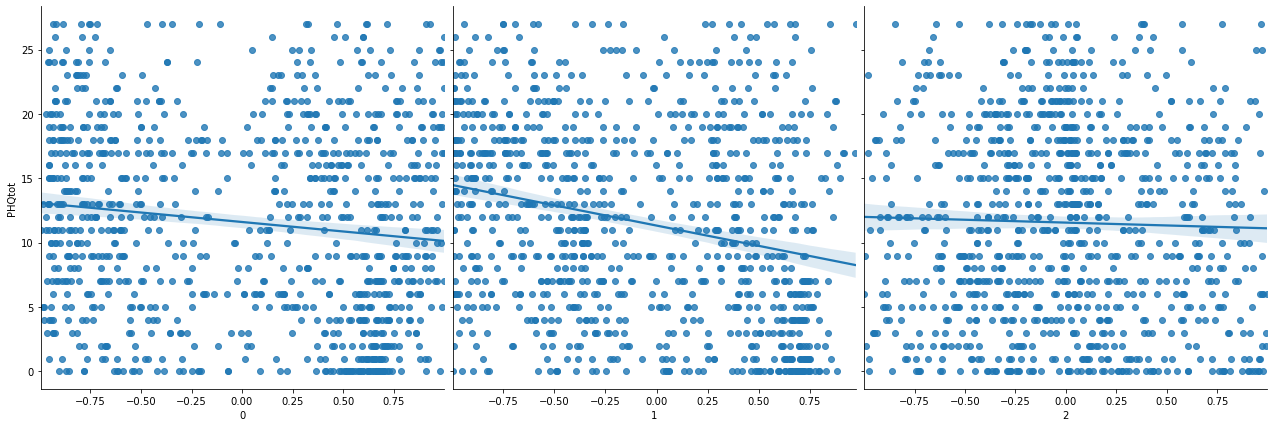

In [14]:
df_plot_dep, df_plot_wor = reduce_dim(3)
df_plot_dep.columns = ['0', '1', '2']
df_plot_wor.columns = ['0', '1', '2']

df_plot_dep['PHQtot'] = responses.PHQtot
df_plot_dep['minidep_diagnose'] = responses.minidep_diagnose

df_plot_wor['GADtot'] = responses.GADtot
df_plot_wor['miniGAD_diagnose'] = responses.miniGAD_diagnose

sns.pairplot(df_plot_dep, x_vars=['0', '1', '2'], y_vars='PHQtot', height=6, kind='reg')

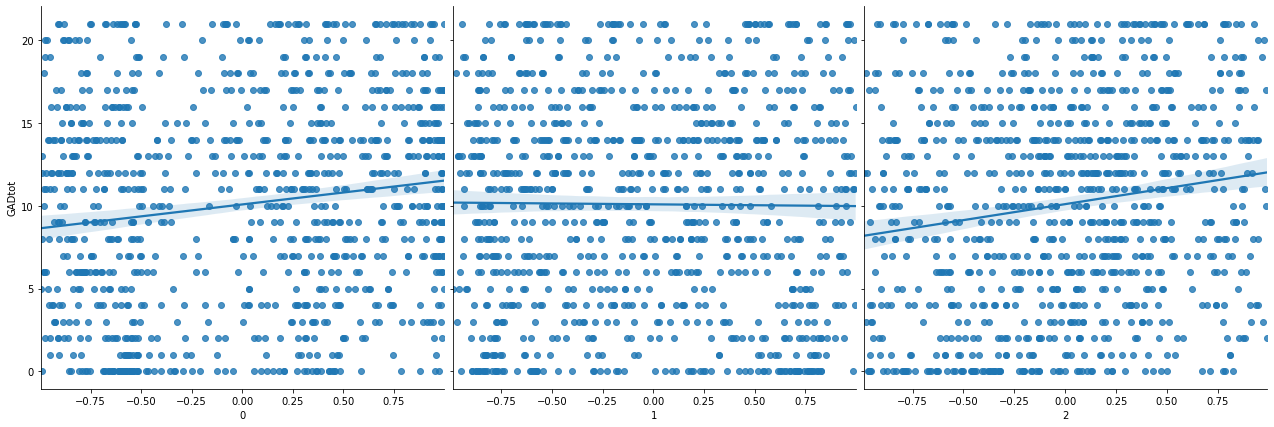

In [15]:
sns.pairplot(df_plot_wor, x_vars=['0', '1', '2'], y_vars='GADtot', height=6, kind='reg')

### Dimension Reduction using UMAP

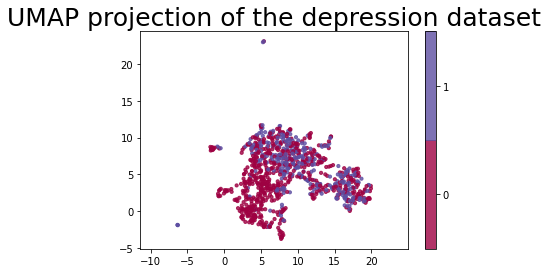

In [19]:
"""Will use umap by: constructing a model, training the model, and then looking at the transformed data"""

reducer_dep = umap.UMAP(n_neighbors=3, min_dist=0.5)

#embedding = reducer.fit_transform(reduce_dim(56)[0]) #uses vectors with reduced dimensions (after PCA)
embedding_dep = reducer_dep.fit_transform(df_dep_concat) #uses full concatinated vectors with 2048 dimensions (before PCA)

#plot the embedding as a standard scatterplot and color by the target array
plt.scatter(embedding_dep[:, 0], embedding_dep[:, 1], c=y_dep_diag, cmap='Spectral', s=10, alpha=0.8)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection of the depression dataset', fontsize=25)
plt.show()

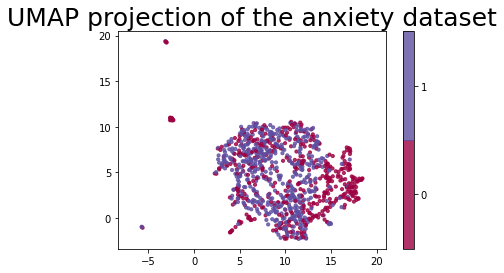

In [20]:
"""Will use umap by: constructing a model, training the model, and then looking at the transformed data"""

reducer_wor = umap.UMAP(n_neighbors=3, min_dist=0.5)

#embedding = reducer.fit_transform(reduce_dim(74)[1]) #uses vectors with reduced dimensions (after PCA)
embedding_wor = reducer_wor.fit_transform(df_wor_concat) #uses full concatinated vectors with 2048 dimensions (before PCA)

#plot the embedding as a standard scatterplot and color by the target array
plt.scatter(embedding_wor[:, 0], embedding_wor[:, 1], c=y_wor_diag, cmap='Spectral', s=10, alpha=0.8)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection of the anxiety dataset', fontsize=25)
plt.show()

"""Will use umap by: constructing a model, training the model, and then looking at the transformed data"""

reducer_wor = umap.UMAP(n_neighbors=3, min_dist=0.5)


### Plotting feature 1 vs. feature 2 and coloring after diagnosis

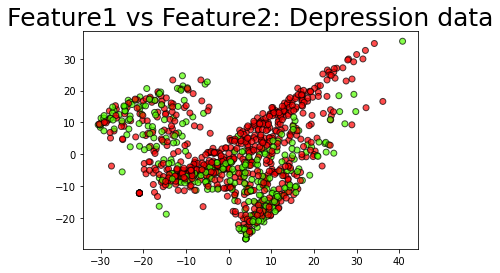

In [21]:
# Reduces concatinated response vectors into two dimensions and plots dim1 vs dim2. Colored after dep diagnosis.

X_pca_dep = reduce_dim(2, normalize=False)[0]

plt.scatter(X_pca_dep.values[:, 0], X_pca_dep.values[:, 1], c=y_dep_diag, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title('Feature1 vs Feature2: Depression data', fontsize=25)
plt.show()


**OBS**, using 2 dim only explains 14.9% (or PCA1: 8.8%, PCA2: 6.2%) of variance/information and hence should not be seen as a reliable representation/plot. In order to conserve 85% of the variance we need 220 dimensions.

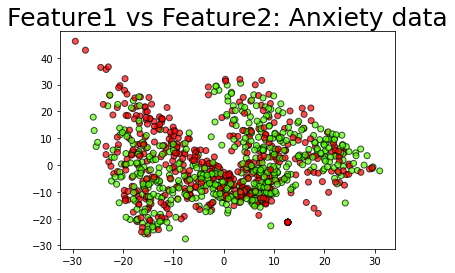

In [22]:
# Reduces concatinated response vectors into two dimensions and plots dim1 vs dim2. Colored after dep diagnosis.

X_pca_wor = reduce_dim(2, normalize=False)[1]

plt.scatter(X_pca_wor.values[:, 0], X_pca_wor.values[:, 1], c=y_wor_diag, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title('Feature1 vs Feature2: Anxiety data', fontsize=25)
plt.show()
 

**OBS**, using 2 dim only explains **14.4%** (or PCA1: 8.0%, PCA2: 6.3%) of variance/information and hence, should not be seen as a reliable representation/plot. In order to conserve 85% of the variance we need 222 dimensions.

#### Plots of linear regression residuals

In [56]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

x_dep = df_dep_concat.values

scaler = StandardScaler()
pca_res = PCA(n_components=23)

X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

# Standardize and scale data
scaler.fit(X_train_dep) 
X_train_dep = scaler.transform(X_train_dep)
X_test_dep = scaler.transform(X_test_dep)

# Fit and reduce dimensions
pca_res.fit(X_train_dep)
X_train_dep = pca_res.transform(X_train_dep)
X_test_dep = pca_res.transform(X_test_dep)

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X_train_dep, y_train_dep)
visualizer.score(X_test_dep, y_test_dep)
visualizer.show()


In [ ]:
x_wor = df_wor_concat.values

scaler = StandardScaler()
pca_res = PCA(n_components=56)

X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

# Standardize and scale data
scaler.fit(X_train_wor) 
X_train_wor = scaler.transform(X_train_wor)
X_test_wor = scaler.transform(X_test_wor)

# Fit and reduce dimensions
pca_res.fit(X_train_wor)
X_train_wor = pca_res.transform(X_train_wor)
X_test_wor = pca_res.transform(X_test_wor)

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X_train_wor, y_train_wor)
visualizer.score(X_test_wor, y_test_wor)
visualizer.show()

# Using the Semantic Representations in Analyses

Import packages needed for analysis

In [27]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from numpy import mean
from numpy import std
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from matplotlib import pyplot


## Analysis using logistic regression

### Depression

In [28]:
#Datasets to use for analysis using logistic regression
X_dep = df_dep.values #the non-normalized version
X_train, X_test, y_train, y_test = train_test_split(X_dep, y_dep_diag,
                                                    test_size=0.2)

X_train_norm=preprocessing.normalize(X_train, norm='l2')
X_test_norm=preprocessing.normalize(X_test, norm='l2')

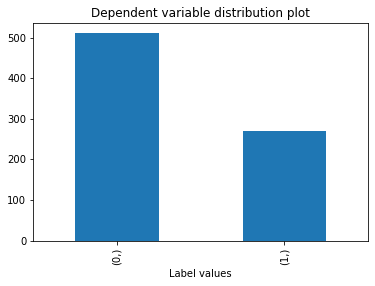

In [30]:
pd.DataFrame(y_train).value_counts().plot(kind='bar')
plt.title('Dependent variable distribution plot')
plt.xlabel('Label values')
plt.show()

### Analysing number of components to use for PCA 

In [31]:

def get_models():
    models = dict()
    for i in range(1,200): 
        steps = [('pca', PCA(n_components=i)), ('model', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
max_score, n_components=0,0
for name, model in models.items():
    scores = evaluate_model(model, X_train_norm, y_train)
    mean_scores=mean(scores)
    if mean_scores > max_score:
        max_score=mean_scores
        max_components=n_components
    n_components+=1
    
print(n_components) #3 #50 #199

199


In [ ]:
#Getting the total variance explained by the choice of principal components

sum_variance, n_component, n = 0, 0, 0
chosen_n_components=n_components
pca=PCA(n_components=chosen_n_components)
pca.fit(X_train_norm, y_train)

while n_component < chosen_n_components:
    sum_variance += pca.explained_variance_ratio_[n_component]
    n_component += 1

print('Total variance explained by the chosen '+ str(chosen_n_components)+' number of components:', str(sum_variance*100)+'%')

#Total variance explained by the chosen 50 number of components: 70.05372717054635%
#Total variance explained by the chosen 3 number of components: 30 %
#Total variance explained by the chosen 199 number of components: 91.6108049451644%

In [32]:
#Create, fit and transform PCA object
chosen_n_components=3
print(chosen_n_components)
pca = PCA(n_components=chosen_n_components)
pca.fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)


model = LogisticRegression().fit(X_train_pca, y_train)
y_pred_train = model.predict(X_train_pca)
y_pred_test = model.predict(X_test_pca)


3


In [33]:
#Performance evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

#todo: result table 


Training Set Accuracy: 65.38461538461539%
Testing Set Accuracy: 72.44897959183673%


Results with n=3:
Training Set Accuracy: 70.76923076923077%
Testing Set Accuracy: 70.91836734693877%

Training Set Accuracy: 71.02564102564102%
Testing Set Accuracy: 70.40816326530613%

Training Set Accuracy: 71.02564102564102%
Testing Set Accuracy: 68.87755102040816%

Training Set Accuracy: 70.8974358974359%
Testing Set Accuracy: 70.40816326530613%

Training Set Accuracy: 70.76923076923077%
Testing Set Accuracy: 69.89795918367348%

Training Set Accuracy: 70.76923076923077%
Testing Set Accuracy: 71.42857142857143%

Training Set Accuracy: 64.61538461538461%
Testing Set Accuracy: 73.46938775510205%

Results with n=199:
Training Set Accuracy: 72.17948717948718%
Testing Set Accuracy: 70.91836734693877%

Training Set Accuracy: 71.7948717948718%
Testing Set Accuracy: 70.40816326530613%

In [34]:
#get performance by class
pd.crosstab(y_test, y_pred_test, margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,All
Actual,,
0,142,142
1,54,54
All,196,196


### Analysing number of components to use for PCA - part two (using GridSearchCV)

Results:
Training Set Accuracy: 64.61538461538461%
Testing Set Accuracy: 73.46938775510205%

In [35]:
#Selecting dimensionality reduction with pipeline and GridSearchCV

pipe = Pipeline(steps=[('pca', PCA()), ('model', LogisticRegression())])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [3, 5, 15, 30, 45, 50, 64, 127, 199],
    'model__C': np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)

search.fit(X_train_norm, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.654):
{'model__C': 0.0001, 'pca__n_components': 3}


### Regularization parameter tuning

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-4, 3, 500) #-4,4,4

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_train_norm, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


LogisticRegressionCV(Cs=array([1.00000000e-04, 1.03282813e-04, 1.06673394e-04, 1.10175281e-04,
       1.13792129e-04, 1.17527712e-04, 1.21385926e-04, 1.25370799e-04,
       1.29486487e-04, 1.33737286e-04, 1.38127630e-04, 1.42662102e-04,
       1.47345431e-04, 1.52182505e-04, 1.57178372e-04, 1.62338243e-04,
       1.67667503e-04, 1.73171713e-04, 1.78856616e-04, 1.84728144e-04,
       1.90792422e-04, 1.97...
       5.41336030e+02, 5.59107078e+02, 5.77461515e+02, 5.96418495e+02,
       6.15997796e+02, 6.36219849e+02, 6.57105755e+02, 6.78677305e+02,
       7.00957009e+02, 7.23968114e+02, 7.47734631e+02, 7.72281357e+02,
       7.97633907e+02, 8.23818733e+02, 8.50863158e+02, 8.78795401e+02,
       9.07644607e+02, 9.37440879e+02, 9.68215306e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, verbose=1)

In [43]:
logit_searcher.C_

array([0.41613906])

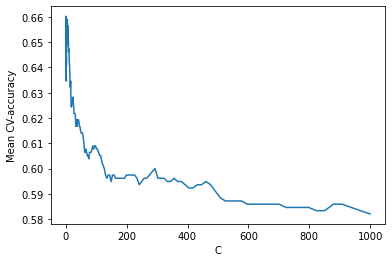

In [44]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy'); 
#To see how the quality of the model (percentage of correct responses on the training and validation sets) 
#varies with the hyperparameter C


In [53]:

chosen_c_value=0.01
chosen_n_components=3


model = make_pipeline(PCA(n_components=chosen_n_components), LogisticRegression(C=chosen_c_value)) 
model.fit(X_train, y_train)
pred_test_model = model.predict(X_test)


model2 = make_pipeline(PCA(n_components=chosen_n_components), LogisticRegressionCV())
model2.fit(X_train, y_train)
pred_test_model2 = model2.predict(X_test)


# Show prediction accuracies 
print('Model 1 testing set accuracy {:.2%}\n '.format(metrics.accuracy_score(y_test, pred_test_model)))
mcc=metrics.matthews_corrcoef(y_test, pred_test_model)
print(mcc) 
#print(balanced_accuracy_score(y_test, pred_test_model)) 

print('Model 2 testing set accuracy {:.2%}\n'.format(metrics.accuracy_score(y_test, pred_test_model2)))
mcc2=metrics.matthews_corrcoef(y_test, pred_test_model2)
print(mcc2) 
#print(balanced_accuracy_score(y_test, pred_test_model2)) 


#The best value is 1 and the worst value is 0 when adjusted=False.
#when adjusted=True he result is adjusted for chance, 
#so that random performance would score 0, while keeping perfect performance at a score of 1.

#Max 74.49 for model 1 and model 3 with n_components 3 and C=0.0001, same value with c=0.01, 
#for model 2 with this the MCC score is negative...

#Thoughts: Playing around with c value and nbr of components makes a big difference. 


Model 1 testing set accuracy 72.45%
 
0.0
Model 2 testing set accuracy 72.45%

0.0


/Users/alexandraantgren/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/alexandraantgren/opt/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The Matthews correlation coefficient (+1 represents a perfect prediction, 0 an average 
random prediction and -1 and inverse prediction).
If any of the terms in the denominator evaluates to 0, the MCC score is undefined. 
It tends to happen in the early stages of training because the model is basically doing random predictions at that stage. It can also happen if the model is being trained with too large learning rates 
because the model will end up predicting the same label for all inputs.

In [54]:
tn, fp, fn, tp = confusion_matrix(y_pred_test,y_test).ravel()
print(tn, fp, fn, tp)
pd.crosstab(y_test, y_pred_test, margins=True, rownames=['Actual'], colnames=['Predicted'])

142 54 0 0


Predicted,0,All
Actual,,
0,142,142
1,54,54
All,196,196


In [ ]:
#TODO:Visualisation of results to compare the different models 

## Analysis using plain linear regression and numerical scales as dependent variable 

### Depression

**Mean Absolute Error (MAE):** $$MAE = \frac{1}{n}\sum^n_{i=1}|y_i-\hat{y_i}|$$
**Mean Squared Error (MSE):** $$MSE = \frac{1}{n}\sum^n_{i=1}(y_i-\hat{y_i})^2$$
**Root Mean Squared Error (RMSE):** = $$RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(y_i-\hat{y_i})^2}$$

MSE is more popular than MAE because MSE "punishes" larger errors. But, RMSE is even more popular than MSE because RMSE is interpretable in the "y" units.

In [ ]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

#x_dep = df_dep_concat.iloc[:23] #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_dep =  reduce_dim(23)[0] #To use vectors with reduced dimensions (after PCA)

X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

regr_dep = LinearRegression().fit(X_train_dep, y_train_dep)
y_pred_dep = regr_dep.predict(X_test_dep) 

In [ ]:
print("R2 training data:  ", regr_dep.score(X_train_dep, y_train_dep)) #R2 score for training data is 0.8
print("R2 testing data:  ", regr_dep.score(X_test_dep, y_test_dep)) #R2 score for test data is -223.13 
#print("Intercept:  ", regr_dep.intercept_)

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_dep, y_pred_dep)))
print("MAE: ", metrics.mean_absolute_error(y_pred_dep, y_test_dep))
print("MSE: ", metrics.mean_squared_error(y_pred_dep, y_test_dep))

#### Linar regression scaling and pca on training set only:

In [ ]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

x_dep = df_dep_concat.values #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2

scaler = StandardScaler()
pca_reg_dep = PCA(n_components=23)

#pca_reg_dep = PCA(n_components=56) #Instance of PCA that reduces nbr dim until 95% of variance is kept
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

scaler.fit(X_train_dep) #Fit on training set only. (Only fit on the training set!)
X_train_dep = scaler.transform(X_train_dep) # Apply transform to both the training set and the test set.
X_test_dep = scaler.transform(X_test_dep)

pca_reg_dep.fit(X_train_dep) #Fit PCA on training set. (Only fit on the training set!)
X_train_dep = pca_reg_dep.transform(X_train_dep)
X_test_dep = pca_reg_dep.transform(X_test_dep)

regr_dep = LinearRegression().fit(X_train_dep, y_train_dep)
y_pred_dep = regr_dep.predict(X_test_dep) 

In [ ]:
print("R2 training data:  ", regr_dep.score(X_train_dep, y_train_dep)) #R2 score for training data is 0.8
print("R2 testing data:  ", regr_dep.score(X_test_dep, y_test_dep)) #R2 score for test data is -223.13 
#print("Intercept:  ", regr_dep.intercept_)

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_dep, y_pred_dep)))
print("MAE: ", metrics.mean_absolute_error(y_pred_dep, y_test_dep))
print("MSE: ", metrics.mean_squared_error(y_pred_dep, y_test_dep))

#### Worry

In [ ]:


#x_wor = df_wor_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_wor = reduce_dim(56)[1] #To use vectors with reduced dimensions (after PCA)

X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

regr_wor = LinearRegression()
regr_wor.fit(X_train_wor, y_train_wor)

y_pred_wor = regr_wor.predict(X_test_wor)

In [ ]:
print("R2 score training data:  ", regr_wor.score(X_train_wor, y_train_wor)) #R2 score for training data is 0.7 is 0.67
print("R2 score testing data:  ", regr_wor.score(X_test_wor, y_test_wor)) #R2 score for test data is -3

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_wor, y_pred_wor)))
print("MAE: ", metrics.mean_absolute_error(y_pred_wor, y_test_wor))
print("MSE: ", metrics.mean_squared_error(y_pred_wor, y_test_wor))

#### Linar regression scaling and pca on training set only:

In [ ]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

x_wor = df_wor_concat.values #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2

scaler_wor = StandardScaler()
pca_reg_wor = PCA(n_components=56)

X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

scaler_wor.fit(X_train_wor) #Fit on training set only. (Only fit on the training set!)
X_train_wor = scaler_wor.transform(X_train_wor) # Apply transform to both the training set and the test set.
X_test_wor = scaler_wor.transform(X_test_wor)

pca_reg_wor.fit(X_train_wor) #Fit PCA on training set. (Only fit on the training set!)
X_train_wor = pca_reg_wor.transform(X_train_wor)
X_test_wor = pca_reg_wor.transform(X_test_wor)

regr_wor = LinearRegression().fit(X_train_wor, y_train_wor)
y_pred_wor = regr_wor.predict(X_test_wor)

In [ ]:
print("R2 score training data:  ", regr_wor.score(X_train_wor, y_train_wor)) #R2 score for training data is 0.7 is 0.67
print("R2 score testing data:  ", regr_wor.score(X_test_wor, y_test_wor)) #R2 score for test data is -3

print("\nRMSE:", np.sqrt(metrics.mean_squared_error(y_test_wor, y_pred_wor)))
print("MAE: ", metrics.mean_absolute_error(y_pred_wor, y_test_wor))
print("MSE: ", metrics.mean_squared_error(y_pred_wor, y_test_wor))

# Examining optimal number of dimensions

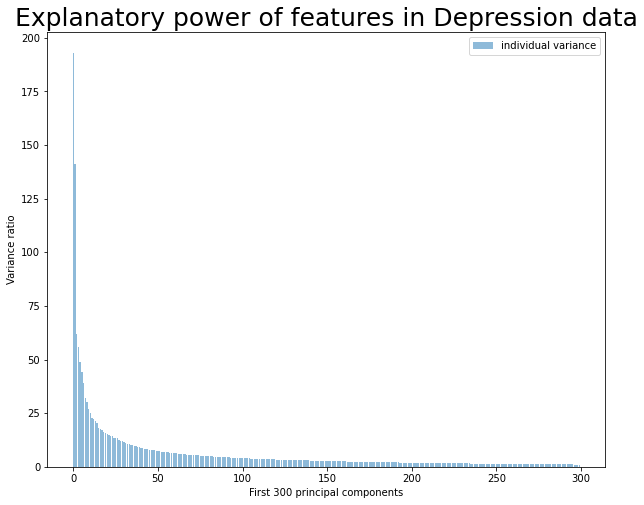

NameError: name 'mpatches' is not defined

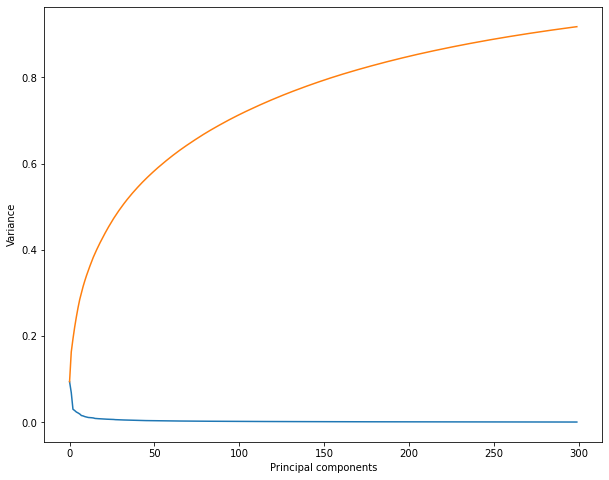

In [57]:
x_dep = df_dep_concat.values
scaler = StandardScaler()
x_dep = scaler.fit_transform(x_dep) 

# Visualize
pca = PCA()
pca.fit_transform(x_dep)
pca_variance = pca.explained_variance_

plt.figure(figsize=(10, 8))
plt.bar(range(300), pca_variance[:300], alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.title('Explanatory power of features in Depression data', fontsize=25)
plt.ylabel('Variance ratio')
plt.xlabel('First 300 principal components')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(range(300), pca.explained_variance_ratio_[:300])
plt.plot(range(300), np.cumsum(pca.explained_variance_ratio_[:300]))
plt.ylabel('Variance')
plt.xlabel('Principal components')
green_patch = mpatches.Patch(color='green', label='total variance')
blue_patch = mpatches.Patch(color='blue', label='individual variance')
plt.legend(handles=[green_patch, blue_patch])
plt.title("Component-wise and Cumulative Explained Variance", fontsize=25)
plt.show()

In [ ]:
x_dep = df_dep_concat.values
scaler = StandardScaler()
x_dep = scaler.fit_transform(x_dep) 

# Visualize
pca = PCA(n_components=30)
pca.fit_transform(x_dep)
pca_variance = pca.explained_variance_

plt.figure(figsize=(10, 8))
plt.bar(range(30), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.title('Explanatory power of features in Depression', fontsize=25)
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(range(30), pca.explained_variance_ratio_)
plt.plot(range(30), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Variance')
plt.xlabel('Principal components')
green_patch = mpatches.Patch(color='green', label='total variance')
blue_patch = mpatches.Patch(color='blue', label='individual variance')
plt.legend(handles=[green_patch, blue_patch])
plt.title("Component-wise and Cumulative Explained Variance", fontsize=25)
plt.show()

### Using the method described in the article combined with plain linear regression

In [ ]:
"""In practice, this was simply achieved by adding 1, 
then multiplying by 1.3 and finally rounding to the nearest integer 
(e.g., 1, 3, 5, 8, where the next number of dimen- sions to be tested are the first 12; 
in other words ([8 􏰃 1] 􏰍 1.3).
In previous research, we have found this sequence to be valid and computationally efficient"""


In [ ]:
#initializing values
n, min_err = 1, np.inf
new_x = df_wor_concat

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)


while n < len(df_wor_concat.columns):
    
    #split data into train and test data
    X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(new_x, y_wor_scale, test_size=0.2, random_state=0)
    y_train_wor = y_train_wor.flatten() 
    y_test_wor = y_test_wor.flatten()
    
    regr_wor = LinearRegression()
    
    #fit data
    regr_wor.fit(X_train_wor, y_train_wor)
    
    #make prediction 
    y_pred_wor = regr_wor.predict(X_test_wor) 
    
    #test prediction with mean squared error 
    err = mean_absolute_error(y_test_wor, y_pred_wor)
    
    #compare err with current min err to then later choose the nbr of dimensions that give minimum mean squared error
    if err < min_err:
        min_err = err
        dimensions = n
        r2 = regr_wor.score(X_test_wor, y_test_wor)
        
    n=round((n+1)*1.3)
    new_x=df_wor_concat.iloc[:,:n] 

print('Nbr of dimensions to use : ', dimensions)
print(min_err)
print(r2)

In [ ]:
"Using the depression data to test how many dimensions to keep"

y_dim = y_dep_scale
dimension, min_error = 0, np.inf
i = 1

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dim = df_dep_concat.iloc[:,:i]
    X_train_dim, X_test_dim, y_train_dim, y_test_dim = train_test_split(x_dim, y_dim, test_size=0.2, random_state=0)

    regr_dim = LinearRegression()
    
    regr_dim.fit(X_train_dim, y_train_dim)
    y_pred_dim = regr_dim.predict(X_test_dim) 
    
    mae = mean_absolute_error(y_test_dim, y_pred_dim)
    
    if mae < min_error: 
        min_error = mae
        dimension = i
        r2 = regr_dim.score(X_test_dim, y_test_dim)
    #print(i, mse)
    i = round((i + 1)*1.3)
    
print('\nNbr of dimensions to use: ', dimension)
print(min_error, r2)

## Cross validation techniques

## Examining optimal number of dimensions using method described in article combined with leave 10% cross validation

### Depression

In [ ]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#reduce_dim(k)[0] => To use dep vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dep_cv = df_dep_concat.iloc[:,:i]
    
    scores = cross_val_score(reg, x_dep_cv, y_dep_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(abs(min_error), dimension))

#### Gradually increase dimensions in PCA and keep best performing number of dims

In [ ]:
#Leave 10% out cross validation while testing the number of dimensions after PCA that will give the best over all score. 

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, np.inf
i = 1

while i < 976:
    x_dep_cv = reduce_dim(i)[0]

    scores = cross_val_score(reg, x_dep_cv, y_dep_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    if abs(scores.mean()) < min_error:
        min_error = abs(scores.mean())
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(abs(min_error), dimension))

### Anxiety

In [ ]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_wor_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#reduce_dim(k)[1] => To use wor vectors with reduced dimensions (after PCA)

while i < len(df_wor_concat.columns):
    x_wor_cv = df_wor_concat.iloc[:,:i]
    
    scores = cross_val_score(reg, x_wor_cv, y_wor_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(abs(min_error), dimension)) 



# Results examining optimal number of dimensions

#### Depression

Technique | Original dimension | R2 score | MSE | MAE | Nbr dimensions
----- | --- | --- | --- | --- | --- |
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.040 | 51.80 | |17
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048	 | 0.136 | 46.62 | |56
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.025 | 6.828 | 5.64 | 74 / 56 (with MAE)
same as over, w/ nltk cleaning | Full concat: 2048 |  |  | 5.77 | 23


#### Anxiety

Technique | Original dimension | R2 score | MSE | MAE | Nbr dimensions
----- | --- | --- | --- | --- | --- |
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.131 | 31.42 | |56
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048 | 0.131 | 31.42 | |98
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.112 | 7.169 | 5.06 | 56 / 31 (with MAE)
same as over, w/ nltk cleaning | Full concat: 2048 |  |  | 5.023 | 56

#### Test: Leave 10% out cross validation on PCA reduced vectors

In [ ]:
#Leave 10% out cross validation using PCA reduced vectors

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
x_dep_cv = reduce_dim(56)[0] #=> To use vectors with reduced dimensions (after PCA)

#Options for scoring: 'r2', 'neg_root_mean_squared_error' 
scores = cross_val_score(reg, x_dep_cv, y_dep_scale, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print(abs(scores))

## Analysis using a basic neural network

In [58]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
pca = PCA(n_components=220)

Y = y_dep_scale
#Y = to_categorical(Y)
X = df_dep_concat.values 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=0)

scaler.fit(X_train) 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import regularizers

model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(32, activation='relu'))
model.add(Dense(28, activation='softmax'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               56576     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 28)                924       
Total params: 100,732
Trainable params: 100,732
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(X_train, y_train, batch_size=100, epochs=100, verbose=1, validation_data=(X_test, y_test))

Train on 780 samples, validate on 196 samples
Epoch 1/100
780/780 [==============================] - 3s 3ms/step - loss: 60.6761 - sparse_categorical_accuracy: 0.0564 - val_loss: 54.0474 - val_sparse_categorical_accuracy: 0.0816
Epoch 2/100
780/780 [==============================] - 0s 324us/step - loss: 50.5128 - sparse_categorical_accuracy: 0.0974 - val_loss: 46.2088 - val_sparse_categorical_accuracy: 0.1071
Epoch 3/100
780/780 [==============================] - 0s 248us/step - loss: 43.2869 - sparse_categorical_accuracy: 0.1244 - val_loss: 39.6697 - val_sparse_categorical_accuracy: 0.1173
Epoch 4/100
780/780 [==============================] - 0s 272us/step - loss: 37.0716 - sparse_categorical_accuracy: 0.1282 - val_loss: 33.8627 - val_sparse_categorical_accuracy: 0.1173
Epoch 5/100
780/780 [==============================] - 0s 315us/step - loss: 31.5321 - sparse_categorical_accuracy: 0.1244 - val_loss: 28.6523 - val_sparse_categorical_accuracy: 0.1327
Epoch 6/100
780/780 [==========

780/780 [==============================] - 1s 1ms/step - loss: 3.5478 - sparse_categorical_accuracy: 0.1295 - val_loss: 3.6417 - val_sparse_categorical_accuracy: 0.0969
Epoch 46/100
780/780 [==============================] - 1s 1ms/step - loss: 3.5456 - sparse_categorical_accuracy: 0.1256 - val_loss: 3.6416 - val_sparse_categorical_accuracy: 0.1020
Epoch 47/100
780/780 [==============================] - 0s 497us/step - loss: 3.5408 - sparse_categorical_accuracy: 0.1205 - val_loss: 3.6431 - val_sparse_categorical_accuracy: 0.1020
Epoch 48/100
780/780 [==============================] - 0s 275us/step - loss: 3.5381 - sparse_categorical_accuracy: 0.1192 - val_loss: 3.6446 - val_sparse_categorical_accuracy: 0.1122
Epoch 49/100
780/780 [==============================] - 0s 361us/step - loss: 3.5371 - sparse_categorical_accuracy: 0.1256 - val_loss: 3.6442 - val_sparse_categorical_accuracy: 0.1071
Epoch 50/100
780/780 [==============================] - 0s 285us/step - loss: 3.5322 - sparse_cat

Epoch 90/100
780/780 [==============================] - 0s 351us/step - loss: 3.2599 - sparse_categorical_accuracy: 0.2000 - val_loss: 3.9243 - val_sparse_categorical_accuracy: 0.0969
Epoch 91/100
780/780 [==============================] - 0s 257us/step - loss: 3.2496 - sparse_categorical_accuracy: 0.2141 - val_loss: 3.9447 - val_sparse_categorical_accuracy: 0.0918
Epoch 92/100
780/780 [==============================] - 0s 293us/step - loss: 3.2476 - sparse_categorical_accuracy: 0.2077 - val_loss: 3.9652 - val_sparse_categorical_accuracy: 0.0969
Epoch 93/100
780/780 [==============================] - 0s 270us/step - loss: 3.2372 - sparse_categorical_accuracy: 0.2103 - val_loss: 3.9705 - val_sparse_categorical_accuracy: 0.0918
Epoch 94/100
780/780 [==============================] - 0s 280us/step - loss: 3.2330 - sparse_categorical_accuracy: 0.2179 - val_loss: 3.9918 - val_sparse_categorical_accuracy: 0.0969
Epoch 95/100
780/780 [==============================] - 0s 315us/step - loss: 3.

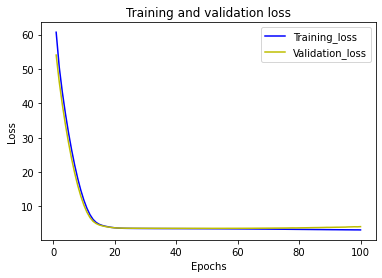

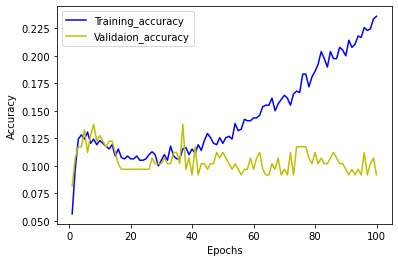

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, 101)
plt.plot(epochs, loss, 'b', label='Training_loss')
plt.plot(epochs, val_loss, 'y', label='Validation_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
plt.plot(epochs, acc, 'b', label='Training_accuracy')
plt.plot(epochs, val_acc, 'y', label='Validaion_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()